In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, re, torch

In [3]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'Slake1.0')
img_dir = os.path.join(data_dir, 'imgs')

In [3]:
!nvidia-smi

Thu Dec 11 18:17:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  |   00000000:24:00.0  On |                  N/A |
| 31%   45C    P8             25W /  220W |    1353MiB /   8192MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset

Load the `SLAKE`.

In [5]:
train_df = pd.read_json(os.path.join(data_dir, 'train.json'))
validate_df = pd.read_json(os.path.join(data_dir, 'validate.json'))
test_df = pd.read_json(os.path.join(data_dir, 'test.json'))

print("train:", train_df.shape)
print("validate:", validate_df.shape)
print("test:", test_df.shape)

train: (9835, 12)
validate: (2099, 12)
test: (2094, 12)


Filter the records that have Chinese questions.

In [6]:
train_df = train_df[train_df['q_lang'] == 'en'].reset_index(drop=True)
validate_df = validate_df[validate_df['q_lang'] == 'en'].reset_index(drop=True)
test_df = test_df[test_df['q_lang'] == 'en'].reset_index(drop=True)

print("train:", train_df.shape)
print("validate:", validate_df.shape)
print("test:", test_df.shape)

train: (4919, 12)
validate: (1053, 12)
test: (1061, 12)


A glance of the dataset.

In [6]:
sample_df = train_df.sample(5)
sample_df

,img_id,img_name,question,answer,q_lang,location,modality,answer_type,base_type,content_type,triple,qid
3754,515,xmlab515/source.jpg,Is this a T1 weighted or T2 weighted MRI image?,T1,en,Brain_Tissue,MRI,CLOSED,vqa,Modality,"[vhead, _, _]",3754
880,216,xmlab216/source.jpg,Does the picture contain heart?,No,en,Abdomen,CT,CLOSED,vqa,Organ,"[vhead, _, _]",880
4232,579,xmlab579/source.jpg,Does the lung exist in this picture?,Yes,en,Abdomen,CT,CLOSED,vqa,Organ,"[vhead, _, _]",4232
149,12,xmlab12/source.jpg,Does the picture contain spleen?,No,en,Abdomen,MRI,CLOSED,vqa,Organ,"[vhead, _, _]",149
3766,516,xmlab516/source.jpg,Where is the brain edema?,Lower Right Lobe,en,Brain_Tissue,MRI,OPEN,vqa,Position,"[vhead, _, _]",3766


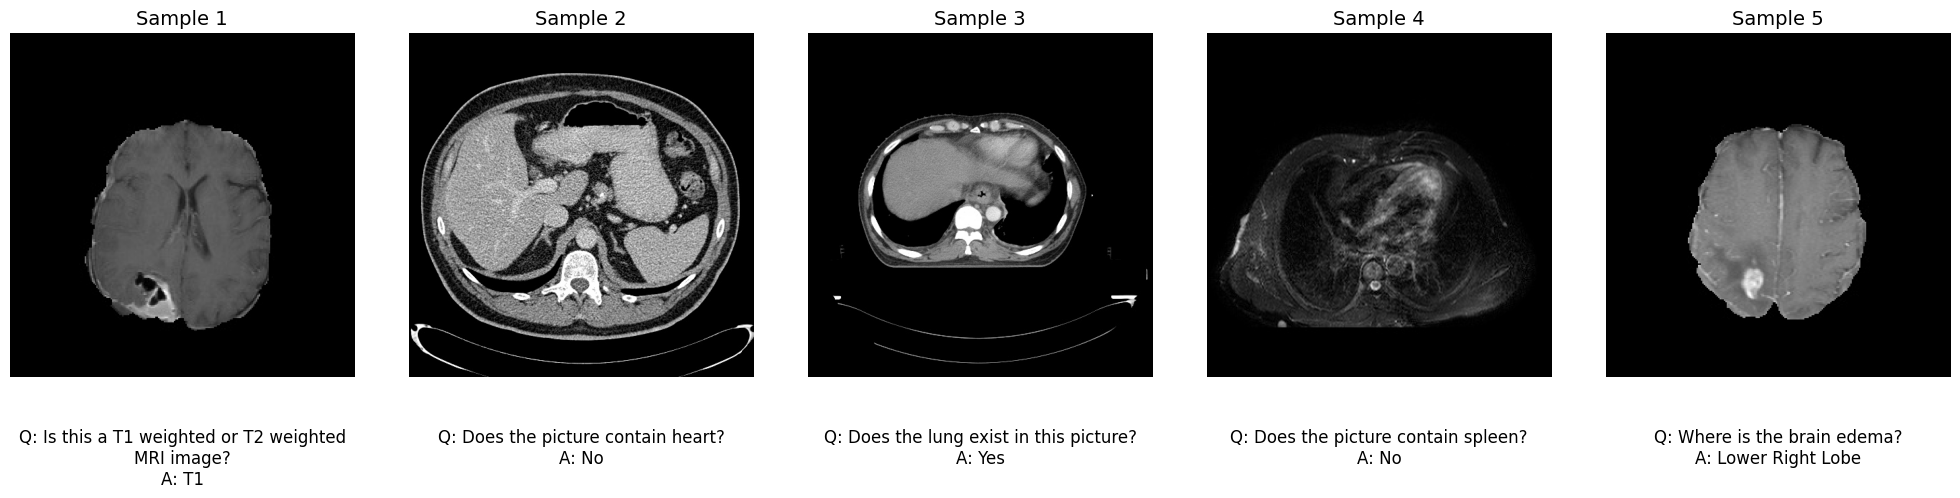

In [7]:
from utils import show_samples
show_samples(sample_df, img_dir=f"{data_dir}\\imgs")

## Baseline

In [8]:
from dataset import Vocab
questions = train_df['question'].tolist()

# Using the Vocab class from before
vocab = Vocab(questions, min_freq=2)
print(f"Vocabulary size: {len(vocab)}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocabulary size: 271


In [9]:
answers = set(train_df['answer'].unique().tolist() + 
              validate_df['answer'].unique().tolist() + 
              test_df['answer'].unique().tolist())
answer2idx = {a: i for i, a in enumerate(sorted(answers))}
idx2answer = {i: a for a, i in answer2idx.items()}
print(f"Number of answer classes: {len(answers)}")

Number of answer classes: 234


Create a DataLoader.

In [10]:
from torchvision import transforms
from dataset import SLAKEDataset
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = SLAKEDataset(train_df, img_dir=img_dir, vocab=vocab, answer2idx=answer2idx, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = SLAKEDataset(validate_df, img_dir=img_dir, vocab=vocab, answer2idx=answer2idx, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = SLAKEDataset(test_df, img_dir=img_dir, vocab=vocab, answer2idx=answer2idx, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train the model.

In [11]:
from baseline import Baseline
from utils import train_epoch, evaluate_epoch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Baseline(len(vocab), embed_dim=300, hidden_dim=512, num_answers=len(answer2idx)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
train_losses, train_accies = [], []
val_losses, val_accies = [], []

for epoch in range(10):
    train_obj = train_epoch(model, train_loader, optimizer, criterion, device)
    val_obj = evaluate_epoch(model, val_loader, criterion, device)
    train_losses.append(train_obj["avg_loss"])
    train_accies.append(train_obj["accuracy"])
    val_losses.append(val_obj["avg_loss"])
    val_accies.append(val_obj["accuracy"])
    
    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_obj['avg_loss']:.4f}, Train Acc={train_obj['accuracy']:.4f}, "
          f"Val Loss={val_obj['avg_loss']:.4f}, Val Acc={val_obj['accuracy']:.4f}")

Epoch 1: Train Loss=3.5839, Train Acc=0.1830, Val Loss=3.0743, Val Acc=0.2308
Epoch 2: Train Loss=2.4480, Train Acc=0.3379, Val Loss=2.1798, Val Acc=0.3846
Epoch 3: Train Loss=1.8402, Train Acc=0.4688, Val Loss=2.0053, Val Acc=0.4103
Epoch 4: Train Loss=1.4909, Train Acc=0.5473, Val Loss=1.5827, Val Acc=0.5223
Epoch 5: Train Loss=1.2650, Train Acc=0.5944, Val Loss=1.4887, Val Acc=0.5432
Epoch 6: Train Loss=1.0930, Train Acc=0.6418, Val Loss=1.3472, Val Acc=0.5850
Epoch 7: Train Loss=0.9383, Train Acc=0.6780, Val Loss=1.2870, Val Acc=0.5992
Epoch 8: Train Loss=0.8504, Train Acc=0.6989, Val Loss=1.2343, Val Acc=0.6144
Epoch 9: Train Loss=0.7134, Train Acc=0.7357, Val Loss=1.2404, Val Acc=0.6211
Epoch 10: Train Loss=0.6082, Train Acc=0.7745, Val Loss=1.1840, Val Acc=0.6315


Plot the training performance of the model.

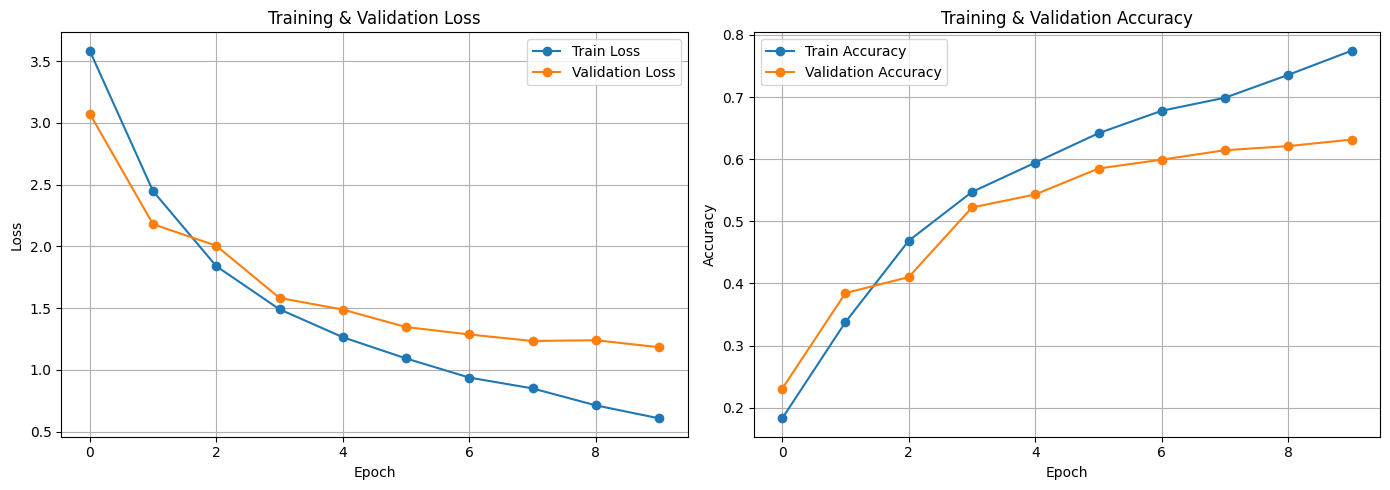

In [12]:
from utils import plot_training_curves
plot_training_curves(train_losses, val_losses, train_accies, val_accies)

Test the model.

In [13]:
test_obj = evaluate_epoch(model, test_loader, criterion, device)
print(f"Test loss: {test_obj['accuracy']:.4f}, Test Accuracy: {test_obj['accuracy']:.4f}")

Test loss: 0.6305, Test Accuracy: 0.6305


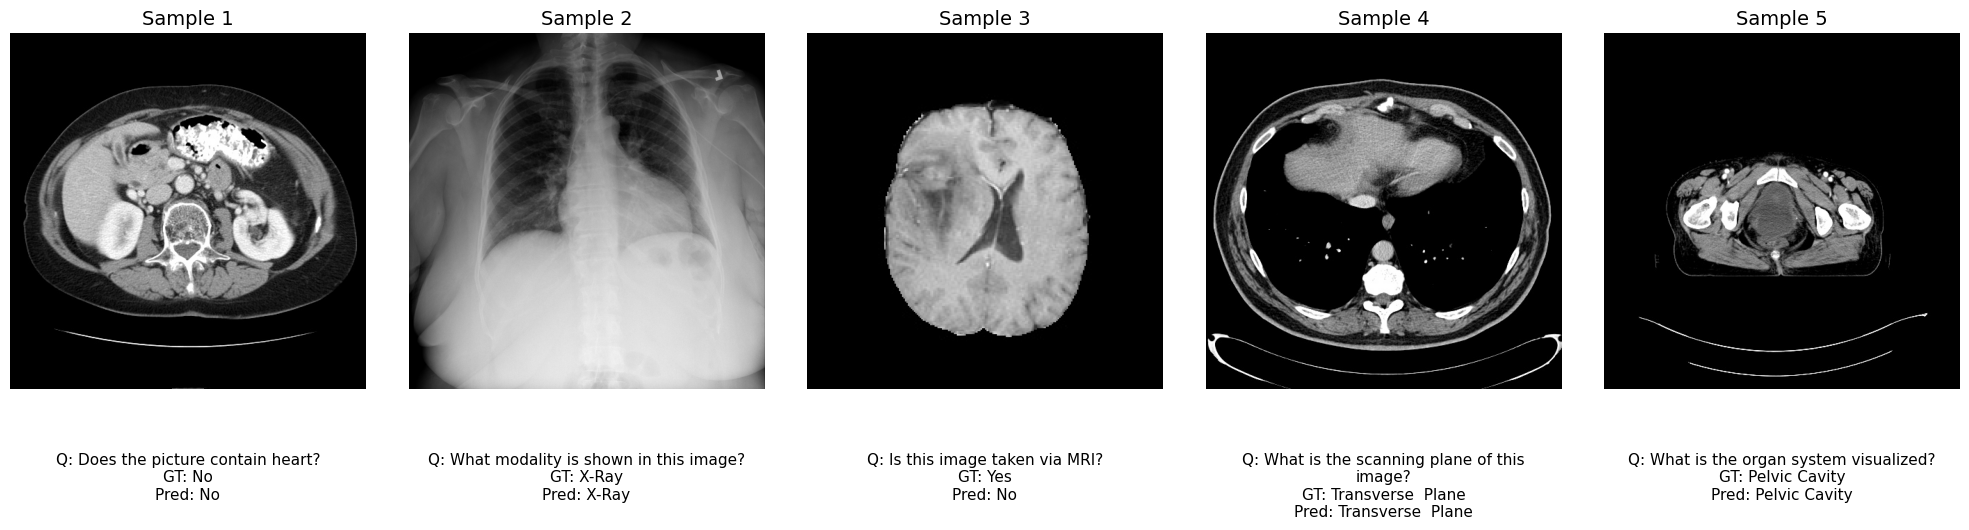

In [14]:
from utils import show_test_samples

pred_answers = [idx2answer[p] for p in test_obj["preds"]]
show_test_samples(test_df, img_dir=img_dir, pred_answers=pred_answers, num_samples=5)